In [ ]:
#importing libraries 
#implentation code need some packages of tensorflow which is available in version 1.14.0 so training is also done in same
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import cv2
!pip install tensorflow==1.14.0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D,Flatten,Dense
from tensorflow.keras.optimizers import Adam

import matplotlib.image as mpimg
from imgaug import augmenters as iaa

import random

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [ ]:
#defining funtions 

#### STEP 1 - INITIALIZE DATA
def getName(filePath):
    myImagePathL = filePath.split('/')[-2:]
    myImagePath = os.path.join(myImagePathL[0],myImagePathL[1])
    return myImagePath

def importDataInfo(path):
    columns = ['Center','Steering']
    noOfFolders = len(os.listdir(path))//2
    data = pd.DataFrame()
    for x in range(1,7):
        dataNew = pd.read_csv(os.path.join(path, f'log_{x}.csv'), names = columns)
        print(f'{x}:{dataNew.shape[0]} ',end='')
        #### REMOVE FILE PATH AND GET ONLY FILE NAME
        #print(getName(data['center'][0]))
        dataNew['Center']=dataNew['Center'].apply(getName)
        data =data.append(dataNew,True )
    print(' ')
    print('Total Images Imported',data.shape[0])
    return data

#### STEP 2 - VISUALIZE AND BALANCE DATA
def balanceData(data,display=True):
    nBin = 31
    samplesPerBin = 400
    hist, bins = np.histogram(data['Steering'], nBin)
    if display:
        center = (bins[:-1] + bins[1:]) * 0.5
        plt.bar(center, hist, width=0.03)
        plt.plot((np.min(data['Steering']), np.max(data['Steering'])), (samplesPerBin, samplesPerBin))
        plt.title('Data Visualisation')
        plt.xlabel('Steering Angle')
        plt.ylabel('No of Samples')
        plt.show()
    removeindexList = []
    for j in range(nBin):
        binDataList = []
        for i in range(len(data['Steering'])):
            if data['Steering'][i] >= bins[j] and data['Steering'][i] <= bins[j + 1]:
                binDataList.append(i)
        binDataList = shuffle(binDataList)
        binDataList = binDataList[samplesPerBin:]
        removeindexList.extend(binDataList)

    print('Removed Images:', len(removeindexList))
    data.drop(data.index[removeindexList], inplace=True)
    print('Remaining Images:', len(data))
    if display:
        hist, _ = np.histogram(data['Steering'], (nBin))
        plt.bar(center, hist, width=0.03)
        plt.plot((np.min(data['Steering']), np.max(data['Steering'])), (samplesPerBin, samplesPerBin))
        plt.title('Balanced Data')
        plt.xlabel('Steering Angle')
        plt.ylabel('No of Samples')
        plt.show()
    return data

#### STEP 3 - PREPARE FOR PROCESSING
def loadData(path, data):
  imagesPath = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    imagesPath.append( os.path.join(path,indexed_data[0]))
    steering.append(float(indexed_data[1]))
  imagesPath = np.asarray(imagesPath)
  steering = np.asarray(steering)
  return imagesPath, steering


#### STEP 5 - AUGMENT DATA
def augmentImage(imgPath,steering):
    img =  mpimg.imread(imgPath)
    if np.random.rand() < 0.5:
        pan = iaa.Affine(translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)})
        img = pan.augment_image(img)
    if np.random.rand() < 0.5:
        zoom = iaa.Affine(scale=(1, 1.2))
        img = zoom.augment_image(img)
    if np.random.rand() < 0.5:
        brightness = iaa.Multiply((0.5, 1.2))
        img = brightness.augment_image(img)
    if np.random.rand() < 0.5:
        img = cv2.flip(img, 1)
        steering = -steering
    return img, steering

# imgRe,st = augmentImage('DataCollected/IMG18/Image_1601839810289305.jpg',0)
# #mpimg.imsave('Result.jpg',imgRe)
# plt.imshow(imgRe)
# plt.show()

#### STEP 6 - PREPROCESS
def preProcess(img):
    img = img[54:120,:,:]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img,  (3, 3), 0)
    img = cv2.resize(img, (200, 66))
    img = img/255
    return img

# imgRe = preProcess(mpimg.imread('DataCollected/IMG18/Image_1601839810289305.jpg'))
# # mpimg.imsave('Result.jpg',imgRe)
# plt.imshow(imgRe)
# plt.show()

#### STEP 7 - CREATE MODEL
def createModel():
  model = Sequential()

  model.add(Convolution2D(24, (5, 5), (2, 2), input_shape=(66, 200, 3), activation='elu'))
  model.add(Convolution2D(36, (5, 5), (2, 2), activation='elu'))
  model.add(Convolution2D(48, (5, 5), (2, 2), activation='elu'))
  model.add(Convolution2D(64, (3, 3), activation='elu'))
  model.add(Convolution2D(64, (3, 3), activation='elu'))

  model.add(Flatten())
  model.add(Dense(100, activation = 'elu'))
  model.add(Dense(50, activation = 'elu'))
  model.add(Dense(10, activation = 'elu'))
  model.add(Dense(1))

  model.compile(Adam(learning_rate=0.0001),loss='mse')
  return model

#### STEP 8 - TRAINNING
def dataGen(imagesPath, steeringList, batchSize, trainFlag):
    while True:
        imgBatch = []
        steeringBatch = []

        for i in range(batchSize):
            index = random.randint(0, len(imagesPath) - 1)
            if trainFlag:
                img, steering = augmentImage(imagesPath[index], steeringList[index])
            else:
                img = mpimg.imread(imagesPath[index])
                steering = steeringList[index]
            img = preProcess(img)
            imgBatch.append(img)
            steeringBatch.append(steering)
        yield (np.asarray(imgBatch),np.asarray(steeringBatch))

In [ ]:
#importing collected data from google drive 
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
print('Setting UP')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from sklearn.model_selection import train_test_split
#from utlis import *


#### STEP 1 - INITIALIZE DATA'
path = '/content/drive/MyDrive/BOT_DATA '
data = importDataInfo(path)
print(data.head())

Setting UP
1:773 2:611 3:1190 4:671 5:664 6:695  
Total Images Imported 4604
                            Center  Steering
0  IMG1/Image_1664724445030133.jpg       0.0
1   IMG1/Image_166472444507728.jpg       0.0
2  IMG1/Image_1664724445115743.jpg       0.0
3  IMG1/Image_1664724445171555.jpg       0.0
4  IMG1/Image_1664724445193869.jpg       0.0


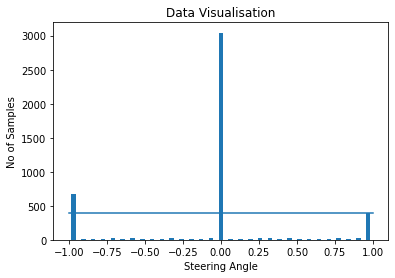

Removed Images: 2912
Remaining Images: 1692


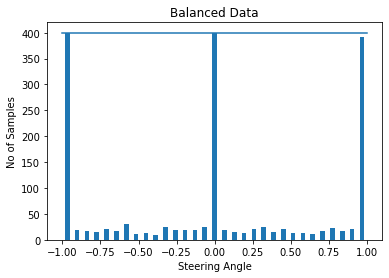

In [ ]:
#path created has majority path straight so max no of images has steering angle 0 
#if the data is not balanced then model will generalize to move straight all the time 

#### STEP 2 - VISUALIZE AND BALANCE DATA
data = balanceData(data,display=True)


In [ ]:
#### STEP 3 - PREPARE FOR PROCESSING
imagesPath, steerings = loadData(path,data)



In [ ]:
#### STEP 4 - SPLIT FOR TRAINING AND VALIDATION
xTrain, xVal, yTrain, yVal = train_test_split(imagesPath, steerings,
                                              test_size=0.2,random_state=10)
print('Total Training Images: ',len(xTrain))
print('Total Validation Images: ',len(xVal))


Total Training Images:  1353
Total Validation Images:  339


In [ ]:
#### STEP 5 - AUGMENT DATA

#### STEP 6 - PREPROCESS

#### STEP 7 - CREATE MODEL
model = createModel()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [ ]:
#### STEP 8 - TRAINNING
history = model.fit(dataGen(xTrain, yTrain, 100, 1),
                                  steps_per_epoch=100,
                                  epochs=10,
                                  validation_data=dataGen(xVal, yVal, 50, 0),
                                  validation_steps=50)

Epoch 1/10
100/100 [==============================] - 462s 5s/step - loss: 0.3136 - val_loss: 0.2549
Epoch 2/10
100/100 [==============================] - 96s 961ms/step - loss: 0.2770 - val_loss: 0.2535
Epoch 3/10
100/100 [==============================] - 95s 950ms/step - loss: 0.2621 - val_loss: 0.2494
Epoch 4/10
100/100 [==============================] - 91s 915ms/step - loss: 0.2606 - val_loss: 0.2763
Epoch 5/10
100/100 [==============================] - 95s 953ms/step - loss: 0.2529 - val_loss: 0.2811
Epoch 6/10
100/100 [==============================] - 95s 947ms/step - loss: 0.2470 - val_loss: 0.2883
Epoch 7/10
100/100 [==============================] - 92s 916ms/step - loss: 0.2482 - val_loss: 0.2450
Epoch 8/10
100/100 [==============================] - 95s 948ms/step - loss: 0.2470 - val_loss: 0.2525
Epoch 9/10
100/100 [==============================] - 92s 924ms/step - loss: 0.2548 - val_loss: 0.2420
Epoch 10/10
100/100 [==============================] - 95s 953ms/step - los

In [ ]:
#### STEP 9 - SAVE THE MODEL
model.save('model_114.h5')
print('Model Saved')

Model Saved


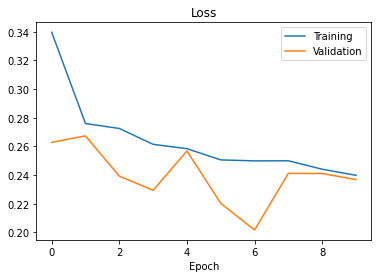

In [ ]:
#### STEP 10 - PLOT THE RESULTS
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.title('Loss')
plt.xlabel('Epoch')
plt.show()